# Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import shutil
import pickle
import numpy as np
import tensorflow as tf
from numpy import argmax
from nltk import flatten
import keras.backend as K
import matplotlib.pyplot as plt

from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
ROOT_PATH = "drive/MyDrive/flickr5k"
IMAGES_PATH = "drive/MyDrive/flickr5k/images"
CAPTIONS_PATH = "drive/MyDrive/flickr5k/captions.txt"

# Load Captions

In [4]:
captions_dic = dict()

f = open(CAPTIONS_PATH, 'r')
for line in f:
    img_name = line.split(',')[0]
    caption = line.split(',')[1].rstrip('\n')
    caption = caption.replace(' .','').lower()
    caption = 'captionbegin ' + caption + ' captionend'

    if img_name not in captions_dic:
        captions_dic[img_name] = []
        
    captions_dic[img_name].append(caption)

In [5]:
len(captions_dic)

5190

In [6]:
tokenizer = Tokenizer()
with open(os.path.join(ROOT_PATH, 'flickr5k_tokenizer.pkl'), 'rb') as f:
    tokenizer = pickle.load(f)

# Extract Image Feature

In [7]:
# load features from pickle
with open(os.path.join(ROOT_PATH, 'flickr5k_features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Create model

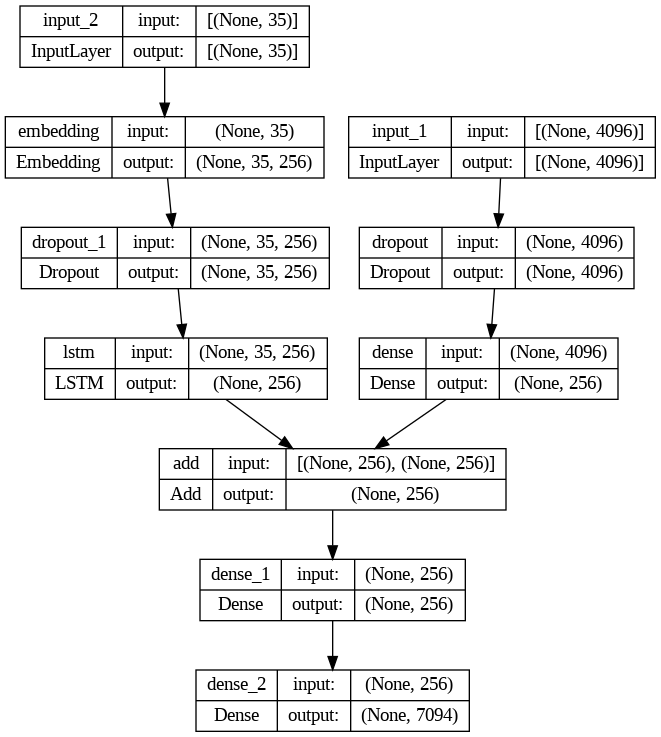

In [8]:
# image feature
inputs1 = Input(shape=(4096,))
img_feature = Dropout(0.4)(inputs1)
img_feature = Dense(256, activation='relu')(img_feature)
# caption feature
inputs2 = Input(shape=(35,))
caption_feature = Embedding(7094, 256, mask_zero=True)(inputs2)
caption_feature = Dropout(0.4)(caption_feature)
caption_feature = LSTM(256)(caption_feature)
# decoder model
decoder1 = add([img_feature, caption_feature])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(7094, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model, show_shapes=True)

In [9]:
def data_generator(captions_dic, features, tokenizer, batch_size):
    while True:
        cur_batch_size = 0
        for key, captions in captions_dic.items():
            if cur_batch_size == 0:
                X1, X2, y = list(), list(), list()
            cur_batch_size += 1
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    # x1: feature, x2: generated caption, y: new word
                    X1.append(features[key][0])
                    X2.append(pad_sequences([seq[:i]], maxlen=35)[0])
                    y.append(to_categorical([seq[i]], num_classes=7094)[0])
            if cur_batch_size == batch_size:
                yield [np.array(X1), np.array(X2)], np.array(y)
                cur_batch_size = 0

In [10]:
# train the model
batch_size = 32
n = len(captions_dic) // batch_size

generator = data_generator(captions_dic, features, tokenizer, batch_size)
model.fit(generator, epochs=20, steps_per_epoch=n, verbose=1)

model.save(ROOT_PATH+'/flickr5k_model.h5')

Epoch 1/20
162/162 [==============================] - 67s 357ms/step - loss: 5.1571
Epoch 2/20
162/162 [==============================] - 43s 263ms/step - loss: 3.8670
Epoch 3/20
162/162 [==============================] - 42s 260ms/step - loss: 3.3877
Epoch 4/20
162/162 [==============================] - 41s 256ms/step - loss: 3.1188
Epoch 5/20
162/162 [==============================] - 43s 265ms/step - loss: 2.9295
Epoch 6/20
162/162 [==============================] - 45s 275ms/step - loss: 2.7791
Epoch 7/20
162/162 [==============================] - 47s 288ms/step - loss: 2.6635
Epoch 8/20
162/162 [==============================] - 44s 269ms/step - loss: 2.5701
Epoch 9/20
162/162 [==============================] - 43s 267ms/step - loss: 2.4889
Epoch 10/20
162/162 [==============================] - 43s 264ms/step - loss: 2.4156
Epoch 11/20
162/162 [==============================] - 43s 264ms/step - loss: 2.3513
Epoch 12/20
162/162 [==============================] - 42s 261ms/step - lo